In [26]:
import ultralytics
from ultralytics import YOLO
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import supervision as sv
import seaborn as sns
from PIL import Image
import random
import time

In [27]:
ultralytics.checks()

Ultralytics YOLOv8.0.220 🚀 Python-3.11.6 torch-2.1.1+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
Setup complete ✅ (16 CPUs, 15.3 GB RAM, 324.4/425.5 GB disk)


In [28]:
model = YOLO("yolov8n.yaml") 
model = YOLO("yolov8n.pt","v8")

model2 = YOLO("yolov8s.yaml") 
model2 = YOLO("yolov8s.pt","v8")

model3 = YOLO("yolov8m.yaml") 
model3 = YOLO("yolov8m.pt","v8")


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1     37248  ultralytics.nn.modules.block.C2f             [192, 64, 1]                  
 16                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    123648  ultralytics.nn.modules.block.C2f             [192, 128, 1]                 
 19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384,

In [30]:
file = open("utils/coco.txt", "r")
data = file.read()
class_list = data.split("\n")
file.close()
class_list

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [31]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_fps = 24.0
output_width = 640
output_height = 480
output_file = 'output.avi'

cap = cv2.VideoCapture("campus.mp4")

original_video_length = cap.get(cv2.CAP_PROP_FRAME_COUNT)
original_video_fps = cap.get(cv2.CAP_PROP_FPS)

#video bilgileri 
print("Orijinal Video FPS Değeri:",original_video_fps)
print("Videodaki Frame Sayısı:",original_video_length)
output_fps = original_video_fps * original_video_length / 720
print("Output Video FPS Değeri:",output_fps)

video_writer = cv2.VideoWriter(output_file, fourcc, output_fps, (output_width, output_height))

frame_width = 640
frame_height = 480
detection_colors = []
for i in range(len(class_list)):
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    detection_colors.append((b, g, r))

Orijinal Video FPS Değeri: 23.97
Videodaki Frame Sayısı: 584.0
Output Video FPS Değeri: 19.442333333333334


In [ ]:
while True:
    # Frame by frame orijinal videodan okuyoruz
    ret, frame = cap.read()
    if not ret:
        print("Frameler bitti!")
        break

    #Frame resize
    frame = cv2.resize(frame, (frame_width, frame_height))

    # Frame'i modele verip prediction alıyoruz.
    detect_params = model.predict(source=[frame], conf=0.35, save=False)
    #Prediction parametrelerini outputlamak için 
    DP = detect_params[0].numpy()

    # Detection frame outputlarının process edildiği kısım 
    if len(DP) != 0:
        for i in range(len(detect_params[0])):
            boxes = detect_params[0].boxes
            box = boxes[i]
            clsID = box.cls.numpy()[0]
            conf = box.conf.numpy()[0]
            bb = box.xyxy.numpy()[0]

            # Detect edilen objecti bb ile mark et
            cv2.rectangle(
                frame,
                (int(bb[0]), int(bb[1])),
                (int(bb[2]), int(bb[3])),
                detection_colors[int(clsID)],
                2,
            )
            # Detect edilen objectin bb'unu video içinde labella
            font = cv2.FONT_HERSHEY_SIMPLEX  
            cv2.putText(
                frame,
                class_list[int(clsID)] + " " + str(round(conf, 3)) + "%",
                (int(bb[0]), int(bb[1]) - 10),
                font,
                0.4,
                (255, 255, 255),
                2,
            )

    # Process edilen frame'i output videosuna yaz
    video_writer.write(frame)

    # Display frame 
    cv2.imshow("ObjectDetection", frame)

    # Space sinyali gelince terminate et
    if cv2.waitKey(1) & 0xFF == ord(" "):
        break

# Release 
cap.release()
video_writer.release()
cv2.destroyAllWindows()

# Object Detection in ROI with Yolov8n

In [33]:
output_file_roi = 'output_roi.avi'
video_writer = cv2.VideoWriter(output_file_roi, fourcc, output_fps, (output_width, output_height))

## ROI Boundarylerinin Belirlenmesi

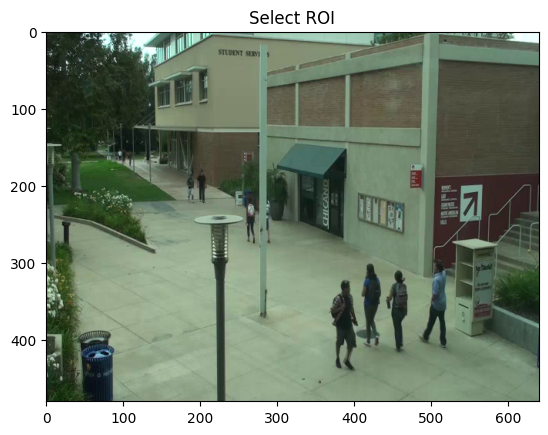

In [44]:
cap = cv2.VideoCapture("campus.mp4")
ret, frame = cap.read()
frame = cv2.resize(frame, (frame_width, frame_height))
rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

cv2.imwrite("crop.jpeg",rgb_frame)

plt.imshow(rgb_frame)
plt.title("Select ROI")
plt.show()

In [45]:
#ROI boundaries
roi_x1 = 280
roi_x2 = 400
roi_y1 = 120
roi_y2 = 320

# ROI içindeki potted plant'i labellamayı da önlemek için
potted_plant_class_label = 'potted plant'
person_class_label = 'person'
person_count = 0
tracked_persons = {}

# FPS değeri üzerinden basit bir performans ölçümü yapmaya çalıştım.
frames_processed = 0
start_time = time.time()

while True:
    # Frame by frame orijinal videodan okuyoruz
    ret, frame = cap.read()
    if not ret:
        print("Frameler bitti!")
        break

    frames_processed += 1

    #Frame resize
    frame = cv2.resize(frame, (frame_width, frame_height))

    #ROI yi video frameleri içinde işaretleyip labelladım
    cv2.rectangle(frame, (roi_x1, roi_y1), (roi_x2, roi_y2), (0, 255, 0), 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, "ROI", (roi_x1, roi_y1 - 10), font, 0.7, (0, 255, 0), 2)

    # YOLO modelinin process edeceği sub frame'i extract ediyorum.
    roi_frame = frame[roi_y1:roi_y2, roi_x1:roi_x2]

    # ROI'yi yoloya verip predictionunu process ediyorum.
    detect_params = model.predict(source=[roi_frame], conf=0.35, save=False)
    DP = detect_params[0].numpy()

    # Detection frame outputlarının process edildiği kısım 
    if len(DP) != 0:
        
        for i in range(len(detect_params[0])):
            boxes = detect_params[0].boxes
            box = boxes[i]
            clsID = box.cls.numpy()[0]
            conf = box.conf.numpy()[0]
            bb = box.xyxy.numpy()[0]

            # İlgilendiğim objectin bb boundarylerinden 
            if ((bb[0] >= roi_x1 or bb[2] <= roi_x2 or bb[1] >= roi_y1 or bb[3] <= roi_y2) and class_list[int(clsID)] != potted_plant_class_label) :

                # Person identification için ilgili personun bb'undan x ve y koordinatlarının centroidlerini hesapladım
                centroid_x = (bb[0] + bb[2]) / 2
                centroid_y = (bb[1] + bb[3]) / 2

                # Eğer bir person'un bb'unun centroidleri frameler arasında belirli bir threshold değerinden az değişiklik gösteriyorsa
                # O personu track etmişiz demektir. Yeni bir person bilgisini vermediği için person_count artırılmaz.
                person_tracked = False
                for person_id, (prev_centroid_x, prev_centroid_y) in tracked_persons.items():
                    distance = np.sqrt((centroid_x - prev_centroid_x)**2 + (centroid_y - prev_centroid_y)**2)

                    # threshold distance'ı. İnsanların hareket hızlarında bir anomali olmadıkça doğru sonuç veriyor.
                    if distance < 35:  
                        person_tracked = True
                        break

                # Eğer eşik değerin üstündeyse ROI'ye yeni bir person girmiş demektir.
                if not person_tracked:
                    person_count += 1
                    tracked_persons[person_count] = (centroid_x, centroid_y)
                
                
                # bb'leri ROI içinde scale ediyorum
                scaled_bb = [
                                bb[0] + roi_x1, #bb[0] top-left corner'ın x koordinatı 
                                bb[1] + roi_y1, #bb[1] top-left corner'ın y koordinatı 
                                bb[2] + roi_x1, #bb[2] bottom-right corner'ın x koordinatı 
                                bb[3] + roi_y1  #bb[3] bottom-right corner'ın y koordinatı 
                            ]
                scaled_bb = [int(coord) for coord in scaled_bb]

                # ROI içindeki objectlerin bb'sinin çizilmesi
                cv2.rectangle(
                    frame,
                    (scaled_bb[0], scaled_bb[1]),
                    (scaled_bb[2], scaled_bb[3]),
                    detection_colors[int(clsID)],
                    1,
                )
                # ROI içindeki objectlerin labellarının yazılması
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(
                    frame,
                    class_list[int(clsID)] + " " + str(round(conf, 3)) + "%",
                    (scaled_bb[0], scaled_bb[1] - 10),
                    font,
                    0.5,
                    (255, 255, 255),
                    2,
                )
                cv2.putText(frame, f"Person Count: {person_count}", (roi_x2, roi_y1 + 20), font, 0.7, (255, 255, 255), 2)
    

    # Process edilen frame'i output videosuna yaz
    video_writer.write(frame)

    # Display frame 
    cv2.imshow("ObjectDetection", frame)

    # Space sinyali gelince terminate et
    if cv2.waitKey(1) & 0xFF == ord(" "):
        break

cap.release()
video_writer.release()
cv2.destroyAllWindows()

elapsed_time_yolov8n = time.time() - start_time
fps_yolov8n = frames_processed / elapsed_time_yolov8n


0: 640x384 1 potted plant, 72.0ms
Speed: 1.5ms preprocess, 72.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 72.2ms
Speed: 2.5ms preprocess, 72.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 66.2ms
Speed: 2.1ms preprocess, 66.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 67.8ms
Speed: 1.8ms preprocess, 67.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 65.1ms
Speed: 2.0ms preprocess, 65.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 67.2ms
Speed: 1.3ms preprocess, 67.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 61.9ms
Speed: 1.1ms preprocess, 61.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 63.5ms
Speed: 2.0ms preprocess, 63.5ms inference

In [46]:
print("ROI'de toplam",person_count,"tane insan görüldü.")
print("yolov8n FPS değeri:",fps_yolov8n)

ROI'de toplam 5 tane insan görüldü.
yolov8n FPS değeri: 12.191407491028162


## Aynı video aynı kod için Yolov8s modeli

In [47]:
output_file_roi2 = 'output_roi2.avi'
video_writer2 = cv2.VideoWriter(output_file_roi2, fourcc, output_fps, (output_width, output_height))
cap = cv2.VideoCapture("campus.mp4")

In [48]:
person_count = 0
tracked_persons = {}

frames_processed = 0
start_time = time.time()

while True:
    
    ret, frame = cap.read()
    if not ret:
        print("Frameler bitti!")
        break

    frames_processed += 1
    frame = cv2.resize(frame, (frame_width, frame_height))

    cv2.rectangle(frame, (roi_x1, roi_y1), (roi_x2, roi_y2), (0, 255, 0), 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, "ROI", (roi_x1, roi_y1 - 10), font, 0.7, (0, 255, 0), 2)

    roi_frame = frame[roi_y1:roi_y2, roi_x1:roi_x2]

    detect_params = model2.predict(source=[roi_frame], conf=0.35, save=False)
    DP = detect_params[0].numpy()

    if len(DP) != 0:
        
        for i in range(len(detect_params[0])):
            boxes = detect_params[0].boxes
            box = boxes[i]
            clsID = box.cls.numpy()[0]
            conf = box.conf.numpy()[0]
            bb = box.xyxy.numpy()[0]

            if ((bb[0] >= roi_x1 or bb[2] <= roi_x2 or bb[1] >= roi_y1 or bb[3] <= roi_y2) and class_list[int(clsID)] != potted_plant_class_label) :

                centroid_x = (bb[0] + bb[2]) / 2
                centroid_y = (bb[1] + bb[3]) / 2

                person_tracked = False
                for person_id, (prev_centroid_x, prev_centroid_y) in tracked_persons.items():
                    distance = np.sqrt((centroid_x - prev_centroid_x)**2 + (centroid_y - prev_centroid_y)**2)

                    if distance < 38:  
                        person_tracked = True
                        break

                if not person_tracked:
                    person_count += 1
                    tracked_persons[person_count] = (centroid_x, centroid_y)
                
                scaled_bb = [
                                bb[0] + roi_x1, 
                                bb[1] + roi_y1, 
                                bb[2] + roi_x1, 
                                bb[3] + roi_y1  
                            ]
                scaled_bb = [int(coord) for coord in scaled_bb]

                cv2.rectangle(
                    frame,
                    (scaled_bb[0], scaled_bb[1]),
                    (scaled_bb[2], scaled_bb[3]),
                    detection_colors[int(clsID)],
                    1,
                )
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(
                    frame,
                    class_list[int(clsID)] + " " + str(round(conf, 3)) + "%",
                    (scaled_bb[0], scaled_bb[1] - 10),
                    font,
                    0.5,
                    (255, 255, 255),
                    2,
                )
                cv2.putText(frame, f"Person Count: {person_count}", (roi_x2, roi_y1 + 20), font, 0.7, (255, 255, 255), 2)

    video_writer2.write(frame)
    cv2.imshow("ObjectDetection", frame)
    if cv2.waitKey(1) & 0xFF == ord(" "):
        break

cap.release()
video_writer2.release()
cv2.destroyAllWindows()

elapsed_time_yolov8s = time.time() - start_time
fps_yolov8s = frames_processed / elapsed_time_yolov8s


0: 640x384 1 potted plant, 122.6ms
Speed: 1.1ms preprocess, 122.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)



0: 640x384 1 potted plant, 130.5ms
Speed: 1.0ms preprocess, 130.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 118.0ms
Speed: 1.0ms preprocess, 118.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 110.7ms
Speed: 0.4ms preprocess, 110.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 112.0ms
Speed: 1.0ms preprocess, 112.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 115.2ms
Speed: 1.5ms preprocess, 115.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 113.3ms
Speed: 1.0ms preprocess, 113.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 114.8ms
Speed: 1.0ms preprocess, 114.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 117.8ms
Speed: 1.0ms preprocess, 11

In [49]:
print("ROI'de toplam",person_count,"tane insan görüldü.")
print("yolov8s FPS değeri:",fps_yolov8s)

ROI'de toplam 4 tane insan görüldü.
yolov8s FPS değeri: 7.615685126747947


## Aynı video aynı kod için Yolov8m modeli

In [50]:
output_file_roi3 = 'output_roi3.avi'
video_writer3 = cv2.VideoWriter(output_file_roi3, fourcc, output_fps, (output_width, output_height))
cap = cv2.VideoCapture("campus.mp4")

In [51]:
person_count = 0
tracked_persons = {}

frames_processed = 0
start_time = time.time()

while True:
    
    ret, frame = cap.read()
    if not ret:
        print("Frameler bitti!")
        break

    frames_processed += 1
    frame = cv2.resize(frame, (frame_width, frame_height))

    cv2.rectangle(frame, (roi_x1, roi_y1), (roi_x2, roi_y2), (0, 255, 0), 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, "ROI", (roi_x1, roi_y1 - 10), font, 0.7, (0, 255, 0), 2)

    roi_frame = frame[roi_y1:roi_y2, roi_x1:roi_x2]

    detect_params = model3.predict(source=[roi_frame], conf=0.35, save=False)
    DP = detect_params[0].numpy()

    if len(DP) != 0:
        
        for i in range(len(detect_params[0])):
            boxes = detect_params[0].boxes
            box = boxes[i]
            clsID = box.cls.numpy()[0]
            conf = box.conf.numpy()[0]
            bb = box.xyxy.numpy()[0]

            if ((bb[0] >= roi_x1 or bb[2] <= roi_x2 or bb[1] >= roi_y1 or bb[3] <= roi_y2) and class_list[int(clsID)] != potted_plant_class_label) :

                
                centroid_x = (bb[0] + bb[2]) / 2
                centroid_y = (bb[1] + bb[3]) / 2

                person_tracked = False
                for person_id, (prev_centroid_x, prev_centroid_y) in tracked_persons.items():
                    distance = np.sqrt((centroid_x - prev_centroid_x)**2 + (centroid_y - prev_centroid_y)**2)

                    if distance < 45:  
                        person_tracked = True
                        break

                if not person_tracked:
                    person_count += 1
                    tracked_persons[person_count] = (centroid_x, centroid_y)
                
                scaled_bb = [
                                bb[0] + roi_x1, 
                                bb[1] + roi_y1, 
                                bb[2] + roi_x1, 
                                bb[3] + roi_y1  
                            ]
                scaled_bb = [int(coord) for coord in scaled_bb]

                cv2.rectangle(
                    frame,
                    (scaled_bb[0], scaled_bb[1]),
                    (scaled_bb[2], scaled_bb[3]),
                    detection_colors[int(clsID)],
                    1,
                )
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(
                    frame,
                    class_list[int(clsID)] + " " + str(round(conf, 3)) + "%",
                    (scaled_bb[0], scaled_bb[1] - 10),
                    font,
                    0.5,
                    (255, 255, 255),
                    2,
                )
                cv2.putText(frame, f"Person Count: {person_count}", (roi_x2, roi_y1 + 20), font, 0.7, (255, 255, 255), 2)

    video_writer3.write(frame)
    cv2.imshow("ObjectDetection", frame)
    if cv2.waitKey(1) & 0xFF == ord(" "):
        break

cap.release()
video_writer3.release()
cv2.destroyAllWindows()

elapsed_time_yolov8m = time.time() - start_time
fps_yolov8m = frames_processed / elapsed_time_yolov8m
    

0: 640x384 1 potted plant, 237.9ms
Speed: 2.0ms preprocess, 237.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 238.3ms
Speed: 2.0ms preprocess, 238.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 224.1ms
Speed: 1.2ms preprocess, 224.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 228.6ms
Speed: 0.6ms preprocess, 228.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 234.6ms
Speed: 2.0ms preprocess, 234.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 219.2ms
Speed: 2.0ms preprocess, 219.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 218.9ms
Speed: 1.5ms preprocess, 218.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 potted plant, 216.9ms
Speed: 1.9ms preprocess, 21

In [52]:
print("ROI'de toplam",person_count,"tane insan görüldü.")
print("yolov8m FPS değeri:",fps_yolov8m)

ROI'de toplam 4 tane insan görüldü.
yolov8m FPS değeri: 4.196281993683115


## Frame'in içinden arbitrary bir ROI seçilmesi

In [53]:
img_path="crop.jpeg"

img_raw = cv2.imread(img_path)

roi = cv2.selectROI(img_raw)

roi_x1, roi_y1, roi_width, roi_height = roi
roi_x2 = roi_x1 + roi_width
roi_y2 = roi_y1 + roi_height

print(roi)

cv2.imwrite("custom_roi.jpeg",roi)

roi_cropped = img_raw[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]

cv2.imshow("ROI", roi_cropped)
cv2.imwrite("custom_roi_cropped.jpeg",roi_cropped)
cv2.waitKey(0)

(348, 276, 214, 189)


32

In [54]:
output_file_roi4 = 'output_roi4.avi'
video_writer4 = cv2.VideoWriter(output_file_roi4, fourcc, output_fps, (output_width, output_height))
cap = cv2.VideoCapture("C:\\Users\\oguzd\\OneDrive\\Masaüstü\\YOLOv8\\venv\\campus.mp4")

In [55]:
person_count = 0
tracked_persons = {}

frames_processed = 0
start_time = time.time()

while True:
    
    ret, frame = cap.read()
    if not ret:
        print("Frameler bitti!")
        break

    frames_processed += 1
    frame = cv2.resize(frame, (frame_width, frame_height))

    cv2.rectangle(frame, (roi_x1, roi_y1), (roi_x2, roi_y2), (0, 255, 0), 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, "ROI", (roi_x1, roi_y1 - 10), font, 0.7, (0, 255, 0), 2)

    roi_cropped = frame[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]


    detect_params = model.predict(source=[roi_cropped], conf=0.35, save=False)
    DP = detect_params[0].numpy()

    if len(DP) != 0:
        
        for i in range(len(detect_params[0])):
            boxes = detect_params[0].boxes
            box = boxes[i]
            clsID = box.cls.numpy()[0]
            conf = box.conf.numpy()[0]
            bb = box.xyxy.numpy()[0]

            if ((bb[0] >= roi_x1 or bb[2] <= roi_x2 or bb[1] >= roi_y1 or bb[3] <= roi_y2) and class_list[int(clsID)] != potted_plant_class_label) :

                centroid_x = (bb[0] + bb[2]) / 2
                centroid_y = (bb[1] + bb[3]) / 2

                person_tracked = False
                for person_id, (prev_centroid_x, prev_centroid_y) in tracked_persons.items():
                    distance = np.sqrt((centroid_x - prev_centroid_x)**2 + (centroid_y - prev_centroid_y)**2)

                    if distance < 38:  
                        person_tracked = True
                        break

                if not person_tracked:
                    person_count += 1
                    tracked_persons[person_count] = (centroid_x, centroid_y)
                
                scaled_bb = [
                                bb[0] + roi_x1, 
                                bb[1] + roi_y1, 
                                bb[2] + roi_x1, 
                                bb[3] + roi_y1  
                            ]
                scaled_bb = [int(coord) for coord in scaled_bb]

                cv2.rectangle(
                    frame,
                    (scaled_bb[0], scaled_bb[1]),
                    (scaled_bb[2], scaled_bb[3]),
                    detection_colors[int(clsID)],
                    1,
                )
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(
                    frame,
                    class_list[int(clsID)] + " " + str(round(conf, 3)) + "%",
                    (scaled_bb[0], scaled_bb[1] - 10),
                    font,
                    0.5,
                    (255, 255, 255),
                    2,
                )
                cv2.putText(frame, f"Person Count: {person_count}", (roi_x2, roi_y1 + 20), font, 0.7, (255, 255, 255), 2)

    video_writer4.write(frame)
    cv2.imshow("ObjectDetection", frame)
    if cv2.waitKey(1) & 0xFF == ord(" "):
        break

cap.release()
video_writer4.release()
cv2.destroyAllWindows()


0: 576x640 4 persons, 96.5ms
Speed: 3.1ms preprocess, 96.5ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 4 persons, 84.9ms
Speed: 1.4ms preprocess, 84.9ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 4 persons, 75.8ms
Speed: 1.4ms preprocess, 75.8ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 4 persons, 71.4ms
Speed: 1.7ms preprocess, 71.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 4 persons, 72.0ms
Speed: 2.0ms preprocess, 72.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 4 persons, 73.1ms
Speed: 1.4ms preprocess, 73.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 4 persons, 73.4ms
Speed: 1.5ms preprocess, 73.4ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 4 persons, 81.9ms
Speed: 2.5ms preprocess, 81.9ms inference, 1.0ms postprocess per image at shape (1